In [117]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [118]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [119]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

In [120]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 2511
Total Drives: 64609
Total Plays: 455669


In [121]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty"))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

Clean Drives: 64192


In [122]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [123]:
def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr]
    })

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to]
    })

def stringify_entry(team_entry):
    return team_entry.tolist()[0]

def calculate_five_factors_rating(team_stat_pack):
    return (.35 * team_stat_pack.OffSR) + (.25 * (team_stat_pack.OffER * team_stat_pack.YPP)) + (.15 * (team_stat_pack.FP / 50.0)) + (.15 * ((team_stat_pack.PPD + team_stat_pack.OppSR + team_stat_pack.OppEff)/3)) + (.10 * team_stat_pack.ExpTODiff)

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if (year == 2016):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')
    
    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    home_team_stats['ExpTODiff'] = home_team_stats['ExpTO'] - away_team_stats['ExpTO']
    away_team_stats['ExpTODiff'] = away_team_stats['ExpTO'] - home_team_stats['ExpTO']
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31,-3,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,1.15,-0.66,0.512424,-0.052568
1,Virginia Tech,34,3,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,1.81,0.66,0.564992,0.052568


In [124]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/2511] Getting game information for ESPN game_id: 400869090
[1/2511] Started processing game information for ESPN game_id: 400869090
[1/2511] Completed processing game information for ESPN game_id: 400869090
[1/2511] Aggreggating game_id 400869090 to master data copy
[2/2511] Getting game information for ESPN game_id: 400869421
[2/2511] Started processing game information for ESPN game_id: 400869421
[2/2511] Completed processing game information for ESPN game_id: 400869421
[2/2511] Aggreggating game_id 400869421 to master data copy
[3/2511] Getting game information for ESPN game_id: 400869257
[3/2511] Started processing game information for ESPN game_id: 400869257
[3/2511] Skipping checking game_id 400869257 bc one of the teams isn't FBS
[4/2511] Getting game information for ESPN game_id: 400869502
[4/2511] Started processing game information for ESPN game_id: 400869502
[4/2511] Skipping checking game_id 400869502 bc one of the teams isn't FBS
[5/2511] Getting game information for ES

[35/2511] Completed processing game information for ESPN game_id: 400868976
[35/2511] Aggreggating game_id 400868976 to master data copy
[36/2511] Getting game information for ESPN game_id: 400869507
[36/2511] Started processing game information for ESPN game_id: 400869507
[36/2511] Completed processing game information for ESPN game_id: 400869507
[36/2511] Aggreggating game_id 400869507 to master data copy
[37/2511] Getting game information for ESPN game_id: 400869260
[37/2511] Started processing game information for ESPN game_id: 400869260
[37/2511] Completed processing game information for ESPN game_id: 400869260
[37/2511] Aggreggating game_id 400869260 to master data copy
[38/2511] Getting game information for ESPN game_id: 400869509
[38/2511] Started processing game information for ESPN game_id: 400869509
[38/2511] Skipping checking game_id 400869509 bc one of the teams isn't FBS
[39/2511] Getting game information for ESPN game_id: 400869267
[39/2511] Started processing game infor

[71/2511] Completed processing game information for ESPN game_id: 400868973
[71/2511] Aggreggating game_id 400868973 to master data copy
[72/2511] Getting game information for ESPN game_id: 400868957
[72/2511] Started processing game information for ESPN game_id: 400868957
[72/2511] Completed processing game information for ESPN game_id: 400868957
[72/2511] Aggreggating game_id 400868957 to master data copy
[73/2511] Getting game information for ESPN game_id: 400869624
[73/2511] Started processing game information for ESPN game_id: 400869624
[73/2511] Skipping checking game_id 400869624 bc one of the teams isn't FBS
[74/2511] Getting game information for ESPN game_id: 400868969
[74/2511] Started processing game information for ESPN game_id: 400868969
[74/2511] Completed processing game information for ESPN game_id: 400868969
[74/2511] Aggreggating game_id 400868969 to master data copy
[75/2511] Getting game information for ESPN game_id: 400868887
[75/2511] Started processing game infor

[107/2511] Completed processing game information for ESPN game_id: 400869184
[107/2511] Aggreggating game_id 400869184 to master data copy
[108/2511] Getting game information for ESPN game_id: 400869101
[108/2511] Started processing game information for ESPN game_id: 400869101
[108/2511] Completed processing game information for ESPN game_id: 400869101
[108/2511] Aggreggating game_id 400869101 to master data copy
[109/2511] Getting game information for ESPN game_id: 400869277
[109/2511] Started processing game information for ESPN game_id: 400869277
[109/2511] Completed processing game information for ESPN game_id: 400869277
[109/2511] Aggreggating game_id 400869277 to master data copy
[110/2511] Getting game information for ESPN game_id: 400869433
[110/2511] Started processing game information for ESPN game_id: 400869433
[110/2511] Skipping checking game_id 400869433 bc one of the teams isn't FBS
[111/2511] Getting game information for ESPN game_id: 400868877
[111/2511] Started proces

[142/2511] Completed processing game information for ESPN game_id: 400868987
[142/2511] Aggreggating game_id 400868987 to master data copy
[143/2511] Getting game information for ESPN game_id: 400869612
[143/2511] Started processing game information for ESPN game_id: 400869612
[143/2511] Completed processing game information for ESPN game_id: 400869612
[143/2511] Aggreggating game_id 400869612 to master data copy
[144/2511] Getting game information for ESPN game_id: 400868981
[144/2511] Started processing game information for ESPN game_id: 400868981
[144/2511] Completed processing game information for ESPN game_id: 400868981
[144/2511] Aggreggating game_id 400868981 to master data copy
[145/2511] Getting game information for ESPN game_id: 400869357
[145/2511] Started processing game information for ESPN game_id: 400869357
[145/2511] Completed processing game information for ESPN game_id: 400869357
[145/2511] Aggreggating game_id 400869357 to master data copy
[146/2511] Getting game inf

[176/2511] Completed processing game information for ESPN game_id: 400869281
[176/2511] Aggreggating game_id 400869281 to master data copy
[177/2511] Getting game information for ESPN game_id: 400869519
[177/2511] Started processing game information for ESPN game_id: 400869519
[177/2511] Completed processing game information for ESPN game_id: 400869519
[177/2511] Aggreggating game_id 400869519 to master data copy
[178/2511] Getting game information for ESPN game_id: 400869520
[178/2511] Started processing game information for ESPN game_id: 400869520
[178/2511] Completed processing game information for ESPN game_id: 400869520
[178/2511] Aggreggating game_id 400869520 to master data copy
[179/2511] Getting game information for ESPN game_id: 400869001
[179/2511] Started processing game information for ESPN game_id: 400869001
[179/2511] Completed processing game information for ESPN game_id: 400869001
[179/2511] Aggreggating game_id 400869001 to master data copy
[180/2511] Getting game inf

[209/2511] Completed processing game information for ESPN game_id: 400868993
[209/2511] Aggreggating game_id 400868993 to master data copy
[210/2511] Getting game information for ESPN game_id: 400868996
[210/2511] Started processing game information for ESPN game_id: 400868996
[210/2511] Completed processing game information for ESPN game_id: 400868996
[210/2511] Aggreggating game_id 400868996 to master data copy
[211/2511] Getting game information for ESPN game_id: 400869521
[211/2511] Started processing game information for ESPN game_id: 400869521
[211/2511] Completed processing game information for ESPN game_id: 400869521
[211/2511] Aggreggating game_id 400869521 to master data copy
[212/2511] Getting game information for ESPN game_id: 400869522
[212/2511] Started processing game information for ESPN game_id: 400869522
[212/2511] Completed processing game information for ESPN game_id: 400869522
[212/2511] Aggreggating game_id 400869522 to master data copy
[213/2511] Getting game inf

[239/2511] Completed processing game information for ESPN game_id: 400869634
[239/2511] Aggreggating game_id 400869634 to master data copy
[240/2511] Getting game information for ESPN game_id: 400869363
[240/2511] Started processing game information for ESPN game_id: 400869363
[240/2511] Completed processing game information for ESPN game_id: 400869363
[240/2511] Aggreggating game_id 400869363 to master data copy
[241/2511] Getting game information for ESPN game_id: 400869204
[241/2511] Started processing game information for ESPN game_id: 400869204
[241/2511] Completed processing game information for ESPN game_id: 400869204
[241/2511] Aggreggating game_id 400869204 to master data copy
[242/2511] Getting game information for ESPN game_id: 400869203
[242/2511] Started processing game information for ESPN game_id: 400869203
[242/2511] Completed processing game information for ESPN game_id: 400869203
[242/2511] Aggreggating game_id 400869203 to master data copy
[243/2511] Getting game inf

[271/2511] Completed processing game information for ESPN game_id: 400869816
[271/2511] Aggreggating game_id 400869816 to master data copy
[272/2511] Getting game information for ESPN game_id: 400869365
[272/2511] Started processing game information for ESPN game_id: 400869365
[272/2511] Completed processing game information for ESPN game_id: 400869365
[272/2511] Aggreggating game_id 400869365 to master data copy
[273/2511] Getting game information for ESPN game_id: 400868913
[273/2511] Started processing game information for ESPN game_id: 400868913
[273/2511] Completed processing game information for ESPN game_id: 400868913
[273/2511] Aggreggating game_id 400868913 to master data copy
[274/2511] Getting game information for ESPN game_id: 400869815
[274/2511] Started processing game information for ESPN game_id: 400869815
[274/2511] Skipping checking game_id 400869815 bc one of the teams isn't FBS
[275/2511] Getting game information for ESPN game_id: 400869605
[275/2511] Started proces

[303/2511] Completed processing game information for ESPN game_id: 400869620
[303/2511] Aggreggating game_id 400869620 to master data copy
[304/2511] Getting game information for ESPN game_id: 400869454
[304/2511] Started processing game information for ESPN game_id: 400869454
[304/2511] Completed processing game information for ESPN game_id: 400869454
[304/2511] Aggreggating game_id 400869454 to master data copy
[305/2511] Getting game information for ESPN game_id: 400869294
[305/2511] Started processing game information for ESPN game_id: 400869294
[305/2511] Completed processing game information for ESPN game_id: 400869294
[305/2511] Aggreggating game_id 400869294 to master data copy
[306/2511] Getting game information for ESPN game_id: 400869296
[306/2511] Started processing game information for ESPN game_id: 400869296
[306/2511] Completed processing game information for ESPN game_id: 400869296
[306/2511] Aggreggating game_id 400869296 to master data copy
[307/2511] Getting game inf

[333/2511] Completed processing game information for ESPN game_id: 400869372
[333/2511] Aggreggating game_id 400869372 to master data copy
[334/2511] Getting game information for ESPN game_id: 400869371
[334/2511] Started processing game information for ESPN game_id: 400869371
[334/2511] Completed processing game information for ESPN game_id: 400869371
[334/2511] Aggreggating game_id 400869371 to master data copy
[335/2511] Getting game information for ESPN game_id: 400869010
[335/2511] Started processing game information for ESPN game_id: 400869010
[335/2511] Completed processing game information for ESPN game_id: 400869010
[335/2511] Aggreggating game_id 400869010 to master data copy
[336/2511] Getting game information for ESPN game_id: 400869374
[336/2511] Started processing game information for ESPN game_id: 400869374
[336/2511] Completed processing game information for ESPN game_id: 400869374
[336/2511] Aggreggating game_id 400869374 to master data copy
[337/2511] Getting game inf

[363/2511] Completed processing game information for ESPN game_id: 400869669
[363/2511] Aggreggating game_id 400869669 to master data copy
[364/2511] Getting game information for ESPN game_id: 400869381
[364/2511] Started processing game information for ESPN game_id: 400869381
[364/2511] Completed processing game information for ESPN game_id: 400869381
[364/2511] Aggreggating game_id 400869381 to master data copy
[365/2511] Getting game information for ESPN game_id: 400869021
[365/2511] Started processing game information for ESPN game_id: 400869021
[365/2511] Completed processing game information for ESPN game_id: 400869021
[365/2511] Aggreggating game_id 400869021 to master data copy
[366/2511] Getting game information for ESPN game_id: 400868951
[366/2511] Started processing game information for ESPN game_id: 400868951
[366/2511] Completed processing game information for ESPN game_id: 400868951
[366/2511] Aggreggating game_id 400868951 to master data copy
[367/2511] Getting game inf

[395/2511] Completed processing game information for ESPN game_id: 400869378
[395/2511] Aggreggating game_id 400869378 to master data copy
[396/2511] Getting game information for ESPN game_id: 400869722
[396/2511] Started processing game information for ESPN game_id: 400869722
[396/2511] Completed processing game information for ESPN game_id: 400869722
[396/2511] Aggreggating game_id 400869722 to master data copy
[397/2511] Getting game information for ESPN game_id: 400869134
[397/2511] Started processing game information for ESPN game_id: 400869134
[397/2511] Completed processing game information for ESPN game_id: 400869134
[397/2511] Aggreggating game_id 400869134 to master data copy
[398/2511] Getting game information for ESPN game_id: 400869130
[398/2511] Started processing game information for ESPN game_id: 400869130
[398/2511] Completed processing game information for ESPN game_id: 400869130
[398/2511] Aggreggating game_id 400869130 to master data copy
[399/2511] Getting game inf

[426/2511] Completed processing game information for ESPN game_id: 400869136
[426/2511] Aggreggating game_id 400869136 to master data copy
[427/2511] Getting game information for ESPN game_id: 400869219
[427/2511] Started processing game information for ESPN game_id: 400869219
[427/2511] Completed processing game information for ESPN game_id: 400869219
[427/2511] Aggreggating game_id 400869219 to master data copy
[428/2511] Getting game information for ESPN game_id: 400869672
[428/2511] Started processing game information for ESPN game_id: 400869672
[428/2511] Completed processing game information for ESPN game_id: 400869672
[428/2511] Aggreggating game_id 400869672 to master data copy
[429/2511] Getting game information for ESPN game_id: 400869827
[429/2511] Started processing game information for ESPN game_id: 400869827
[429/2511] Completed processing game information for ESPN game_id: 400869827
[429/2511] Aggreggating game_id 400869827 to master data copy
[430/2511] Getting game inf

[455/2511] Completed processing game information for ESPN game_id: 400869220
[455/2511] Aggreggating game_id 400869220 to master data copy
[456/2511] Getting game information for ESPN game_id: 400869138
[456/2511] Started processing game information for ESPN game_id: 400869138
[456/2511] Completed processing game information for ESPN game_id: 400869138
[456/2511] Aggreggating game_id 400869138 to master data copy
[457/2511] Getting game information for ESPN game_id: 400869223
[457/2511] Started processing game information for ESPN game_id: 400869223
[457/2511] Completed processing game information for ESPN game_id: 400869223
[457/2511] Aggreggating game_id 400869223 to master data copy
[458/2511] Getting game information for ESPN game_id: 400869222
[458/2511] Started processing game information for ESPN game_id: 400869222
[458/2511] Completed processing game information for ESPN game_id: 400869222
[458/2511] Aggreggating game_id 400869222 to master data copy
[459/2511] Getting game inf

[486/2511] Completed processing game information for ESPN game_id: 400869628
[486/2511] Aggreggating game_id 400869628 to master data copy
[487/2511] Getting game information for ESPN game_id: 400869314
[487/2511] Started processing game information for ESPN game_id: 400869314
[487/2511] Completed processing game information for ESPN game_id: 400869314
[487/2511] Aggreggating game_id 400869314 to master data copy
[488/2511] Getting game information for ESPN game_id: 400869546
[488/2511] Started processing game information for ESPN game_id: 400869546
[488/2511] Completed processing game information for ESPN game_id: 400869546
[488/2511] Aggreggating game_id 400869546 to master data copy
[489/2511] Getting game information for ESPN game_id: 400869831
[489/2511] Started processing game information for ESPN game_id: 400869831
[489/2511] Skipping checking game_id 400869831 bc one of the teams isn't FBS
[490/2511] Getting game information for ESPN game_id: 400869833
[490/2511] Started proces

[517/2511] Started processing game information for ESPN game_id: 400869318
[517/2511] Completed processing game information for ESPN game_id: 400869318
[517/2511] Aggreggating game_id 400869318 to master data copy
[518/2511] Getting game information for ESPN game_id: 400869317
[518/2511] Started processing game information for ESPN game_id: 400869317
[518/2511] Completed processing game information for ESPN game_id: 400869317
[518/2511] Aggreggating game_id 400869317 to master data copy
[519/2511] Getting game information for ESPN game_id: 400869835
[519/2511] Started processing game information for ESPN game_id: 400869835
[519/2511] Completed processing game information for ESPN game_id: 400869835
[519/2511] Aggreggating game_id 400869835 to master data copy
[520/2511] Getting game information for ESPN game_id: 400869145
[520/2511] Started processing game information for ESPN game_id: 400869145
[520/2511] Completed processing game information for ESPN game_id: 400869145
[520/2511] Agg

[547/2511] Completed processing game information for ESPN game_id: 400869550
[547/2511] Aggreggating game_id 400869550 to master data copy
[548/2511] Getting game information for ESPN game_id: 400869392
[548/2511] Started processing game information for ESPN game_id: 400869392
[548/2511] Completed processing game information for ESPN game_id: 400869392
[548/2511] Aggreggating game_id 400869392 to master data copy
[549/2511] Getting game information for ESPN game_id: 400869553
[549/2511] Started processing game information for ESPN game_id: 400869553
[549/2511] Completed processing game information for ESPN game_id: 400869553
[549/2511] Aggreggating game_id 400869553 to master data copy
[550/2511] Getting game information for ESPN game_id: 400869147
[550/2511] Started processing game information for ESPN game_id: 400869147
[550/2511] Completed processing game information for ESPN game_id: 400869147
[550/2511] Aggreggating game_id 400869147 to master data copy
[551/2511] Getting game inf

[579/2511] Completed processing game information for ESPN game_id: 400869236
[579/2511] Aggreggating game_id 400869236 to master data copy
[580/2511] Getting game information for ESPN game_id: 400868954
[580/2511] Started processing game information for ESPN game_id: 400868954
[580/2511] Completed processing game information for ESPN game_id: 400868954
[580/2511] Aggreggating game_id 400868954 to master data copy
[581/2511] Getting game information for ESPN game_id: 400869045
[581/2511] Started processing game information for ESPN game_id: 400869045
[581/2511] Completed processing game information for ESPN game_id: 400869045
[581/2511] Aggreggating game_id 400869045 to master data copy
[582/2511] Getting game information for ESPN game_id: 400869630
[582/2511] Started processing game information for ESPN game_id: 400869630
[582/2511] Completed processing game information for ESPN game_id: 400869630
[582/2511] Aggreggating game_id 400869630 to master data copy
[583/2511] Getting game inf

[609/2511] Completed processing game information for ESPN game_id: 400869151
[609/2511] Aggreggating game_id 400869151 to master data copy
[610/2511] Getting game information for ESPN game_id: 400869556
[610/2511] Started processing game information for ESPN game_id: 400869556
[610/2511] Completed processing game information for ESPN game_id: 400869556
[610/2511] Aggreggating game_id 400869556 to master data copy
[611/2511] Getting game information for ESPN game_id: 400869047
[611/2511] Started processing game information for ESPN game_id: 400869047
[611/2511] Completed processing game information for ESPN game_id: 400869047
[611/2511] Aggreggating game_id 400869047 to master data copy
[612/2511] Getting game information for ESPN game_id: 400921256
[612/2511] Started processing game information for ESPN game_id: 400921256
[612/2511] Completed processing game information for ESPN game_id: 400921256
[612/2511] Aggreggating game_id 400921256 to master data copy
[613/2511] Getting game inf

[640/2511] Completed processing game information for ESPN game_id: 400869049
[640/2511] Aggreggating game_id 400869049 to master data copy
[641/2511] Getting game information for ESPN game_id: 400869689
[641/2511] Started processing game information for ESPN game_id: 400869689
[641/2511] Completed processing game information for ESPN game_id: 400869689
[641/2511] Aggreggating game_id 400869689 to master data copy
[642/2511] Getting game information for ESPN game_id: 400868883
[642/2511] Started processing game information for ESPN game_id: 400868883
[642/2511] Completed processing game information for ESPN game_id: 400868883
[642/2511] Aggreggating game_id 400868883 to master data copy
[643/2511] Getting game information for ESPN game_id: 400869631
[643/2511] Started processing game information for ESPN game_id: 400869631
[643/2511] Completed processing game information for ESPN game_id: 400869631
[643/2511] Aggreggating game_id 400869631 to master data copy
[644/2511] Getting game inf

[672/2511] Completed processing game information for ESPN game_id: 400869159
[672/2511] Aggreggating game_id 400869159 to master data copy
[673/2511] Getting game information for ESPN game_id: 400869846
[673/2511] Started processing game information for ESPN game_id: 400869846
[673/2511] Skipping checking game_id 400869846 bc one of the teams isn't FBS
[674/2511] Getting game information for ESPN game_id: 400869405
[674/2511] Started processing game information for ESPN game_id: 400869405
[674/2511] Completed processing game information for ESPN game_id: 400869405
[674/2511] Aggreggating game_id 400869405 to master data copy
[675/2511] Getting game information for ESPN game_id: 400869559
[675/2511] Started processing game information for ESPN game_id: 400869559
[675/2511] Completed processing game information for ESPN game_id: 400869559
[675/2511] Aggreggating game_id 400869559 to master data copy
[676/2511] Getting game information for ESPN game_id: 400869407
[676/2511] Started proces

[702/2511] Completed processing game information for ESPN game_id: 400869065
[702/2511] Aggreggating game_id 400869065 to master data copy
[703/2511] Getting game information for ESPN game_id: 400868884
[703/2511] Started processing game information for ESPN game_id: 400868884
[703/2511] Completed processing game information for ESPN game_id: 400868884
[703/2511] Aggreggating game_id 400868884 to master data copy
[704/2511] Getting game information for ESPN game_id: 400868920
[704/2511] Started processing game information for ESPN game_id: 400868920
[704/2511] Skipping checking game_id 400868920 bc one of the teams isn't FBS
[705/2511] Getting game information for ESPN game_id: 400869059
[705/2511] Started processing game information for ESPN game_id: 400869059
[705/2511] Completed processing game information for ESPN game_id: 400869059
[705/2511] Aggreggating game_id 400869059 to master data copy
[706/2511] Getting game information for ESPN game_id: 400869414
[706/2511] Started proces

[736/2511] Completed processing game information for ESPN game_id: 400869166
[736/2511] Aggreggating game_id 400869166 to master data copy
[737/2511] Getting game information for ESPN game_id: 400869412
[737/2511] Started processing game information for ESPN game_id: 400869412
[737/2511] Completed processing game information for ESPN game_id: 400869412
[737/2511] Aggreggating game_id 400869412 to master data copy
[738/2511] Getting game information for ESPN game_id: 400869251
[738/2511] Started processing game information for ESPN game_id: 400869251
[738/2511] Completed processing game information for ESPN game_id: 400869251
[738/2511] Aggreggating game_id 400869251 to master data copy
[739/2511] Getting game information for ESPN game_id: 400869062
[739/2511] Started processing game information for ESPN game_id: 400869062
[739/2511] Completed processing game information for ESPN game_id: 400869062
[739/2511] Aggreggating game_id 400869062 to master data copy
[740/2511] Getting game inf

[768/2511] Completed processing game information for ESPN game_id: 400869418
[768/2511] Aggreggating game_id 400869418 to master data copy
[769/2511] Getting game information for ESPN game_id: 400869340
[769/2511] Started processing game information for ESPN game_id: 400869340
[769/2511] Completed processing game information for ESPN game_id: 400869340
[769/2511] Aggreggating game_id 400869340 to master data copy
[770/2511] Getting game information for ESPN game_id: 400868885
[770/2511] Started processing game information for ESPN game_id: 400868885
[770/2511] Completed processing game information for ESPN game_id: 400868885
[770/2511] Aggreggating game_id 400868885 to master data copy
[771/2511] Getting game information for ESPN game_id: 400869567
[771/2511] Started processing game information for ESPN game_id: 400869567
[771/2511] Completed processing game information for ESPN game_id: 400869567
[771/2511] Aggreggating game_id 400869567 to master data copy
[772/2511] Getting game inf

[800/2511] Completed processing game information for ESPN game_id: 400869171
[800/2511] Aggreggating game_id 400869171 to master data copy
[801/2511] Getting game information for ESPN game_id: 400869570
[801/2511] Started processing game information for ESPN game_id: 400869570
[801/2511] Completed processing game information for ESPN game_id: 400869570
[801/2511] Aggreggating game_id 400869570 to master data copy
[802/2511] Getting game information for ESPN game_id: 400869417
[802/2511] Started processing game information for ESPN game_id: 400869417
[802/2511] Completed processing game information for ESPN game_id: 400869417
[802/2511] Aggreggating game_id 400869417 to master data copy
[803/2511] Getting game information for ESPN game_id: 400869415
[803/2511] Started processing game information for ESPN game_id: 400869415
[803/2511] Completed processing game information for ESPN game_id: 400869415
[803/2511] Aggreggating game_id 400869415 to master data copy
[804/2511] Getting game inf

[831/2511] Completed processing game information for ESPN game_id: 400926946
[831/2511] Aggreggating game_id 400926946 to master data copy
[832/2511] Getting game information for ESPN game_id: 400868921
[832/2511] Started processing game information for ESPN game_id: 400868921
[832/2511] Completed processing game information for ESPN game_id: 400868921
[832/2511] Aggreggating game_id 400868921 to master data copy
[833/2511] Getting game information for ESPN game_id: 400935282
[833/2511] Started processing game information for ESPN game_id: 400935282
[833/2511] Completed processing game information for ESPN game_id: 400935282
[833/2511] Aggreggating game_id 400935282 to master data copy
[834/2511] Getting game information for ESPN game_id: 400945031
[834/2511] Started processing game information for ESPN game_id: 400945031
[834/2511] Skipping checking game_id 400945031 bc one of the teams isn't FBS
[835/2511] Getting game information for ESPN game_id: 400938887
[835/2511] Started proces

[864/2511] Completed processing game information for ESPN game_id: 400935232
[864/2511] Aggreggating game_id 400935232 to master data copy
[865/2511] Getting game information for ESPN game_id: 400935233
[865/2511] Started processing game information for ESPN game_id: 400935233
[865/2511] Completed processing game information for ESPN game_id: 400935233
[865/2511] Aggreggating game_id 400935233 to master data copy
[866/2511] Getting game information for ESPN game_id: 400935234
[866/2511] Started processing game information for ESPN game_id: 400935234
[866/2511] Completed processing game information for ESPN game_id: 400935234
[866/2511] Aggreggating game_id 400935234 to master data copy
[867/2511] Getting game information for ESPN game_id: 400933836
[867/2511] Started processing game information for ESPN game_id: 400933836
[867/2511] Skipping checking game_id 400933836 bc one of the teams isn't FBS
[868/2511] Getting game information for ESPN game_id: 400935256
[868/2511] Started proces

[899/2511] Completed processing game information for ESPN game_id: 400938888
[899/2511] Aggreggating game_id 400938888 to master data copy
[900/2511] Getting game information for ESPN game_id: 400944828
[900/2511] Started processing game information for ESPN game_id: 400944828
[900/2511] Skipping checking game_id 400944828 bc one of the teams isn't FBS
[901/2511] Getting game information for ESPN game_id: 400934491
[901/2511] Started processing game information for ESPN game_id: 400934491
[901/2511] Skipping checking game_id 400934491 bc one of the teams isn't FBS
[902/2511] Getting game information for ESPN game_id: 400933834
[902/2511] Started processing game information for ESPN game_id: 400933834
[902/2511] Completed processing game information for ESPN game_id: 400933834
[902/2511] Aggreggating game_id 400933834 to master data copy
[903/2511] Getting game information for ESPN game_id: 400933829
[903/2511] Started processing game information for ESPN game_id: 400933829
[903/2511] C

[932/2511] Completed processing game information for ESPN game_id: 400937456
[932/2511] Aggreggating game_id 400937456 to master data copy
[933/2511] Getting game information for ESPN game_id: 400934505
[933/2511] Started processing game information for ESPN game_id: 400934505
[933/2511] Completed processing game information for ESPN game_id: 400934505
[933/2511] Aggreggating game_id 400934505 to master data copy
[934/2511] Getting game information for ESPN game_id: 400934562
[934/2511] Started processing game information for ESPN game_id: 400934562
[934/2511] Completed processing game information for ESPN game_id: 400934562
[934/2511] Aggreggating game_id 400934562 to master data copy
[935/2511] Getting game information for ESPN game_id: 400935242
[935/2511] Started processing game information for ESPN game_id: 400935242
[935/2511] Skipping checking game_id 400935242 bc one of the teams isn't FBS
[936/2511] Getting game information for ESPN game_id: 400933846
[936/2511] Started proces

[968/2511] Completed processing game information for ESPN game_id: 400935261
[968/2511] Aggreggating game_id 400935261 to master data copy
[969/2511] Getting game information for ESPN game_id: 400944897
[969/2511] Started processing game information for ESPN game_id: 400944897
[969/2511] Skipping checking game_id 400944897 bc one of the teams isn't FBS
[970/2511] Getting game information for ESPN game_id: 400944835
[970/2511] Started processing game information for ESPN game_id: 400944835
[970/2511] Skipping checking game_id 400944835 bc one of the teams isn't FBS
[971/2511] Getting game information for ESPN game_id: 400937458
[971/2511] Started processing game information for ESPN game_id: 400937458
[971/2511] Completed processing game information for ESPN game_id: 400937458
[971/2511] Aggreggating game_id 400937458 to master data copy
[972/2511] Getting game information for ESPN game_id: 400944893
[972/2511] Started processing game information for ESPN game_id: 400944893
[972/2511] S

[1000/2511] Completed processing game information for ESPN game_id: 400935270
[1000/2511] Aggreggating game_id 400935270 to master data copy
[1001/2511] Getting game information for ESPN game_id: 400934507
[1001/2511] Started processing game information for ESPN game_id: 400934507
[1001/2511] Completed processing game information for ESPN game_id: 400934507
[1001/2511] Aggreggating game_id 400934507 to master data copy
[1002/2511] Getting game information for ESPN game_id: 400933862
[1002/2511] Started processing game information for ESPN game_id: 400933862
[1002/2511] Completed processing game information for ESPN game_id: 400933862
[1002/2511] Aggreggating game_id 400933862 to master data copy
[1003/2511] Getting game information for ESPN game_id: 400937467
[1003/2511] Started processing game information for ESPN game_id: 400937467
[1003/2511] Completed processing game information for ESPN game_id: 400937467
[1003/2511] Aggreggating game_id 400937467 to master data copy
[1004/2511] G

[1034/2511] Completed processing game information for ESPN game_id: 400933859
[1034/2511] Aggreggating game_id 400933859 to master data copy
[1035/2511] Getting game information for ESPN game_id: 400933854
[1035/2511] Started processing game information for ESPN game_id: 400933854
[1035/2511] Completed processing game information for ESPN game_id: 400933854
[1035/2511] Aggreggating game_id 400933854 to master data copy
[1036/2511] Getting game information for ESPN game_id: 400938611
[1036/2511] Started processing game information for ESPN game_id: 400938611
[1036/2511] Completed processing game information for ESPN game_id: 400938611
[1036/2511] Aggreggating game_id 400938611 to master data copy
[1037/2511] Getting game information for ESPN game_id: 400938613
[1037/2511] Started processing game information for ESPN game_id: 400938613
[1037/2511] Skipping checking game_id 400938613 bc one of the teams isn't FBS
[1038/2511] Getting game information for ESPN game_id: 400938608
[1038/2511]

[1067/2511] Completed processing game information for ESPN game_id: 400934518
[1067/2511] Aggreggating game_id 400934518 to master data copy
[1068/2511] Getting game information for ESPN game_id: 400934561
[1068/2511] Started processing game information for ESPN game_id: 400934561
[1068/2511] Completed processing game information for ESPN game_id: 400934561
[1068/2511] Aggreggating game_id 400934561 to master data copy
[1069/2511] Getting game information for ESPN game_id: 400933864
[1069/2511] Started processing game information for ESPN game_id: 400933864
[1069/2511] Completed processing game information for ESPN game_id: 400933864
[1069/2511] Aggreggating game_id 400933864 to master data copy
[1070/2511] Getting game information for ESPN game_id: 400934514
[1070/2511] Started processing game information for ESPN game_id: 400934514
[1070/2511] Completed processing game information for ESPN game_id: 400934514
[1070/2511] Aggreggating game_id 400934514 to master data copy
[1071/2511] G

[1099/2511] Completed processing game information for ESPN game_id: 400945259
[1099/2511] Aggreggating game_id 400945259 to master data copy
[1100/2511] Getting game information for ESPN game_id: 400938621
[1100/2511] Started processing game information for ESPN game_id: 400938621
[1100/2511] Completed processing game information for ESPN game_id: 400938621
[1100/2511] Aggreggating game_id 400938621 to master data copy
[1101/2511] Getting game information for ESPN game_id: 400938616
[1101/2511] Started processing game information for ESPN game_id: 400938616
[1101/2511] Completed processing game information for ESPN game_id: 400938616
[1101/2511] Aggreggating game_id 400938616 to master data copy
[1102/2511] Getting game information for ESPN game_id: 400938617
[1102/2511] Started processing game information for ESPN game_id: 400938617
[1102/2511] Completed processing game information for ESPN game_id: 400938617
[1102/2511] Aggreggating game_id 400938617 to master data copy
[1103/2511] G

[1131/2511] Completed processing game information for ESPN game_id: 400937486
[1131/2511] Aggreggating game_id 400937486 to master data copy
[1132/2511] Getting game information for ESPN game_id: 400937485
[1132/2511] Started processing game information for ESPN game_id: 400937485
[1132/2511] Completed processing game information for ESPN game_id: 400937485
[1132/2511] Aggreggating game_id 400937485 to master data copy
[1133/2511] Getting game information for ESPN game_id: 400937480
[1133/2511] Started processing game information for ESPN game_id: 400937480
[1133/2511] Completed processing game information for ESPN game_id: 400937480
[1133/2511] Aggreggating game_id 400937480 to master data copy
[1134/2511] Getting game information for ESPN game_id: 400934519
[1134/2511] Started processing game information for ESPN game_id: 400934519
[1134/2511] Completed processing game information for ESPN game_id: 400934519
[1134/2511] Aggreggating game_id 400934519 to master data copy
[1135/2511] G

[1161/2511] Completed processing game information for ESPN game_id: 400935369
[1161/2511] Aggreggating game_id 400935369 to master data copy
[1162/2511] Getting game information for ESPN game_id: 400933879
[1162/2511] Started processing game information for ESPN game_id: 400933879
[1162/2511] Completed processing game information for ESPN game_id: 400933879
[1162/2511] Aggreggating game_id 400933879 to master data copy
[1163/2511] Getting game information for ESPN game_id: 400934520
[1163/2511] Started processing game information for ESPN game_id: 400934520
[1163/2511] Completed processing game information for ESPN game_id: 400934520
[1163/2511] Aggreggating game_id 400934520 to master data copy
[1164/2511] Getting game information for ESPN game_id: 400937481
[1164/2511] Started processing game information for ESPN game_id: 400937481
[1164/2511] Completed processing game information for ESPN game_id: 400937481
[1164/2511] Aggreggating game_id 400937481 to master data copy
[1165/2511] G

[1191/2511] Completed processing game information for ESPN game_id: 400944849
[1191/2511] Aggreggating game_id 400944849 to master data copy
[1192/2511] Getting game information for ESPN game_id: 400938628
[1192/2511] Started processing game information for ESPN game_id: 400938628
[1192/2511] Completed processing game information for ESPN game_id: 400938628
[1192/2511] Aggreggating game_id 400938628 to master data copy
[1193/2511] Getting game information for ESPN game_id: 400981507
[1193/2511] Started processing game information for ESPN game_id: 400981507
[1193/2511] Completed processing game information for ESPN game_id: 400981507
[1193/2511] Aggreggating game_id 400981507 to master data copy
[1194/2511] Getting game information for ESPN game_id: 400934522
[1194/2511] Started processing game information for ESPN game_id: 400934522
[1194/2511] Completed processing game information for ESPN game_id: 400934522
[1194/2511] Aggreggating game_id 400934522 to master data copy
[1195/2511] G

[1223/2511] Completed processing game information for ESPN game_id: 400941816
[1223/2511] Aggreggating game_id 400941816 to master data copy
[1224/2511] Getting game information for ESPN game_id: 400938631
[1224/2511] Started processing game information for ESPN game_id: 400938631
[1224/2511] Completed processing game information for ESPN game_id: 400938631
[1224/2511] Aggreggating game_id 400938631 to master data copy
[1225/2511] Getting game information for ESPN game_id: 400935373
[1225/2511] Started processing game information for ESPN game_id: 400935373
[1225/2511] Completed processing game information for ESPN game_id: 400935373
[1225/2511] Aggreggating game_id 400935373 to master data copy
[1226/2511] Getting game information for ESPN game_id: 400935289
[1226/2511] Started processing game information for ESPN game_id: 400935289
[1226/2511] Completed processing game information for ESPN game_id: 400935289
[1226/2511] Aggreggating game_id 400935289 to master data copy
[1227/2511] G

[1254/2511] Completed processing game information for ESPN game_id: 400944998
[1254/2511] Aggreggating game_id 400944998 to master data copy
[1255/2511] Getting game information for ESPN game_id: 400981508
[1255/2511] Started processing game information for ESPN game_id: 400981508
[1255/2511] Completed processing game information for ESPN game_id: 400981508
[1255/2511] Aggreggating game_id 400981508 to master data copy
[1256/2511] Getting game information for ESPN game_id: 400934528
[1256/2511] Started processing game information for ESPN game_id: 400934528
[1256/2511] Completed processing game information for ESPN game_id: 400934528
[1256/2511] Aggreggating game_id 400934528 to master data copy
[1257/2511] Getting game information for ESPN game_id: 400933889
[1257/2511] Started processing game information for ESPN game_id: 400933889
[1257/2511] Completed processing game information for ESPN game_id: 400933889
[1257/2511] Aggreggating game_id 400933889 to master data copy
[1258/2511] G

[1285/2511] Aggreggating game_id 400945273 to master data copy
[1286/2511] Getting game information for ESPN game_id: 400935296
[1286/2511] Started processing game information for ESPN game_id: 400935296
[1286/2511] Completed processing game information for ESPN game_id: 400935296
[1286/2511] Aggreggating game_id 400935296 to master data copy
[1287/2511] Getting game information for ESPN game_id: 400935299
[1287/2511] Started processing game information for ESPN game_id: 400935299
[1287/2511] Completed processing game information for ESPN game_id: 400935299
[1287/2511] Aggreggating game_id 400935299 to master data copy
[1288/2511] Getting game information for ESPN game_id: 400945277
[1288/2511] Started processing game information for ESPN game_id: 400945277
[1288/2511] Completed processing game information for ESPN game_id: 400945277
[1288/2511] Aggreggating game_id 400945277 to master data copy
[1289/2511] Getting game information for ESPN game_id: 400944994
[1289/2511] Started proces

[1315/2511] Completed processing game information for ESPN game_id: 400938892
[1315/2511] Aggreggating game_id 400938892 to master data copy
[1316/2511] Getting game information for ESPN game_id: 400935301
[1316/2511] Started processing game information for ESPN game_id: 400935301
[1316/2511] Completed processing game information for ESPN game_id: 400935301
[1316/2511] Aggreggating game_id 400935301 to master data copy
[1317/2511] Getting game information for ESPN game_id: 400935384
[1317/2511] Started processing game information for ESPN game_id: 400935384
[1317/2511] Completed processing game information for ESPN game_id: 400935384
[1317/2511] Aggreggating game_id 400935384 to master data copy
[1318/2511] Getting game information for ESPN game_id: 400937503
[1318/2511] Started processing game information for ESPN game_id: 400937503
[1318/2511] Completed processing game information for ESPN game_id: 400937503
[1318/2511] Aggreggating game_id 400937503 to master data copy
[1319/2511] G

[1347/2511] Completed processing game information for ESPN game_id: 400945006
[1347/2511] Aggreggating game_id 400945006 to master data copy
[1348/2511] Getting game information for ESPN game_id: 400944861
[1348/2511] Started processing game information for ESPN game_id: 400944861
[1348/2511] Completed processing game information for ESPN game_id: 400944861
[1348/2511] Aggreggating game_id 400944861 to master data copy
[1349/2511] Getting game information for ESPN game_id: 400935304
[1349/2511] Started processing game information for ESPN game_id: 400935304
[1349/2511] Completed processing game information for ESPN game_id: 400935304
[1349/2511] Aggreggating game_id 400935304 to master data copy
[1350/2511] Getting game information for ESPN game_id: 400937504
[1350/2511] Started processing game information for ESPN game_id: 400937504
[1350/2511] Completed processing game information for ESPN game_id: 400937504
[1350/2511] Aggreggating game_id 400937504 to master data copy
[1351/2511] G

[1378/2511] Completed processing game information for ESPN game_id: 400933902
[1378/2511] Aggreggating game_id 400933902 to master data copy
[1379/2511] Getting game information for ESPN game_id: 400938644
[1379/2511] Started processing game information for ESPN game_id: 400938644
[1379/2511] Completed processing game information for ESPN game_id: 400938644
[1379/2511] Aggreggating game_id 400938644 to master data copy
[1380/2511] Getting game information for ESPN game_id: 400944865
[1380/2511] Started processing game information for ESPN game_id: 400944865
[1380/2511] Skipping checking game_id 400944865 bc one of the teams isn't FBS
[1381/2511] Getting game information for ESPN game_id: 400986609
[1381/2511] Started processing game information for ESPN game_id: 400986609
[1381/2511] Skipping checking game_id 400986609 bc one of the teams isn't FBS
[1382/2511] Getting game information for ESPN game_id: 400935309
[1382/2511] Started processing game information for ESPN game_id: 40093530

[1411/2511] Completed processing game information for ESPN game_id: 400935310
[1411/2511] Aggreggating game_id 400935310 to master data copy
[1412/2511] Getting game information for ESPN game_id: 400935399
[1412/2511] Started processing game information for ESPN game_id: 400935399
[1412/2511] Completed processing game information for ESPN game_id: 400935399
[1412/2511] Aggreggating game_id 400935399 to master data copy
[1413/2511] Getting game information for ESPN game_id: 400935396
[1413/2511] Started processing game information for ESPN game_id: 400935396
[1413/2511] Completed processing game information for ESPN game_id: 400935396
[1413/2511] Aggreggating game_id 400935396 to master data copy
[1414/2511] Getting game information for ESPN game_id: 400933911
[1414/2511] Started processing game information for ESPN game_id: 400933911
[1414/2511] Completed processing game information for ESPN game_id: 400933911
[1414/2511] Aggreggating game_id 400933911 to master data copy
[1415/2511] G

[1443/2511] Completed processing game information for ESPN game_id: 400941837
[1443/2511] Aggreggating game_id 400941837 to master data copy
[1444/2511] Getting game information for ESPN game_id: 400944869
[1444/2511] Started processing game information for ESPN game_id: 400944869
[1444/2511] Completed processing game information for ESPN game_id: 400944869
[1444/2511] Aggreggating game_id 400944869 to master data copy
[1445/2511] Getting game information for ESPN game_id: 400935314
[1445/2511] Started processing game information for ESPN game_id: 400935314
[1445/2511] Completed processing game information for ESPN game_id: 400935314
[1445/2511] Aggreggating game_id 400935314 to master data copy
[1446/2511] Getting game information for ESPN game_id: 400945291
[1446/2511] Started processing game information for ESPN game_id: 400945291
[1446/2511] Completed processing game information for ESPN game_id: 400945291
[1446/2511] Aggreggating game_id 400945291 to master data copy
[1447/2511] G

[1473/2511] Completed processing game information for ESPN game_id: 400935316
[1473/2511] Aggreggating game_id 400935316 to master data copy
[1474/2511] Getting game information for ESPN game_id: 400933918
[1474/2511] Started processing game information for ESPN game_id: 400933918
[1474/2511] Completed processing game information for ESPN game_id: 400933918
[1474/2511] Aggreggating game_id 400933918 to master data copy
[1475/2511] Getting game information for ESPN game_id: 400935408
[1475/2511] Started processing game information for ESPN game_id: 400935408
[1475/2511] Completed processing game information for ESPN game_id: 400935408
[1475/2511] Aggreggating game_id 400935408 to master data copy
[1476/2511] Getting game information for ESPN game_id: 400937515
[1476/2511] Started processing game information for ESPN game_id: 400937515
[1476/2511] Completed processing game information for ESPN game_id: 400937515
[1476/2511] Aggreggating game_id 400937515 to master data copy
[1477/2511] G

[1504/2511] Completed processing game information for ESPN game_id: 400938658
[1504/2511] Aggreggating game_id 400938658 to master data copy
[1505/2511] Getting game information for ESPN game_id: 400944872
[1505/2511] Started processing game information for ESPN game_id: 400944872
[1505/2511] Completed processing game information for ESPN game_id: 400944872
[1505/2511] Aggreggating game_id 400944872 to master data copy
[1506/2511] Getting game information for ESPN game_id: 400935320
[1506/2511] Started processing game information for ESPN game_id: 400935320
[1506/2511] Completed processing game information for ESPN game_id: 400935320
[1506/2511] Aggreggating game_id 400935320 to master data copy
[1507/2511] Getting game information for ESPN game_id: 400934546
[1507/2511] Started processing game information for ESPN game_id: 400934546
[1507/2511] Completed processing game information for ESPN game_id: 400934546
[1507/2511] Aggreggating game_id 400934546 to master data copy
[1508/2511] G

[1534/2511] Completed processing game information for ESPN game_id: 400933923
[1534/2511] Aggreggating game_id 400933923 to master data copy
[1535/2511] Getting game information for ESPN game_id: 400933921
[1535/2511] Started processing game information for ESPN game_id: 400933921
[1535/2511] Skipping checking game_id 400933921 bc one of the teams isn't FBS
[1536/2511] Getting game information for ESPN game_id: 400934555
[1536/2511] Started processing game information for ESPN game_id: 400934555
[1536/2511] Completed processing game information for ESPN game_id: 400934555
[1536/2511] Aggreggating game_id 400934555 to master data copy
[1537/2511] Getting game information for ESPN game_id: 400941844
[1537/2511] Started processing game information for ESPN game_id: 400941844
[1537/2511] Completed processing game information for ESPN game_id: 400941844
[1537/2511] Aggreggating game_id 400941844 to master data copy
[1538/2511] Getting game information for ESPN game_id: 400933922
[1538/2511]

[1564/2511] Completed processing game information for ESPN game_id: 400937524
[1564/2511] Aggreggating game_id 400937524 to master data copy
[1565/2511] Getting game information for ESPN game_id: 400937522
[1565/2511] Started processing game information for ESPN game_id: 400937522
[1565/2511] Completed processing game information for ESPN game_id: 400937522
[1565/2511] Aggreggating game_id 400937522 to master data copy
[1566/2511] Getting game information for ESPN game_id: 400935411
[1566/2511] Started processing game information for ESPN game_id: 400935411
[1566/2511] Completed processing game information for ESPN game_id: 400935411
[1566/2511] Aggreggating game_id 400935411 to master data copy
[1567/2511] Getting game information for ESPN game_id: 400933927
[1567/2511] Started processing game information for ESPN game_id: 400933927
[1567/2511] Skipping checking game_id 400933927 bc one of the teams isn't FBS
[1568/2511] Getting game information for ESPN game_id: 400933924
[1568/2511]

[1595/2511] Completed processing game information for ESPN game_id: 400945028
[1595/2511] Aggreggating game_id 400945028 to master data copy
[1596/2511] Getting game information for ESPN game_id: 400937529
[1596/2511] Started processing game information for ESPN game_id: 400937529
[1596/2511] Completed processing game information for ESPN game_id: 400937529
[1596/2511] Aggreggating game_id 400937529 to master data copy
[1597/2511] Getting game information for ESPN game_id: 400945029
[1597/2511] Started processing game information for ESPN game_id: 400945029
[1597/2511] Completed processing game information for ESPN game_id: 400945029
[1597/2511] Aggreggating game_id 400945029 to master data copy
[1598/2511] Getting game information for ESPN game_id: 400933931
[1598/2511] Started processing game information for ESPN game_id: 400933931
[1598/2511] Completed processing game information for ESPN game_id: 400933931
[1598/2511] Aggreggating game_id 400933931 to master data copy
[1599/2511] G

[1626/2511] Completed processing game information for ESPN game_id: 400937533
[1626/2511] Aggreggating game_id 400937533 to master data copy
[1627/2511] Getting game information for ESPN game_id: 400934558
[1627/2511] Started processing game information for ESPN game_id: 400934558
[1627/2511] Completed processing game information for ESPN game_id: 400934558
[1627/2511] Aggreggating game_id 400934558 to master data copy
[1628/2511] Getting game information for ESPN game_id: 400945307
[1628/2511] Started processing game information for ESPN game_id: 400945307
[1628/2511] Completed processing game information for ESPN game_id: 400945307
[1628/2511] Aggreggating game_id 400945307 to master data copy
[1629/2511] Getting game information for ESPN game_id: 400935421
[1629/2511] Started processing game information for ESPN game_id: 400935421
[1629/2511] Completed processing game information for ESPN game_id: 400935421
[1629/2511] Aggreggating game_id 400935421 to master data copy
[1630/2511] G

[1659/2511] Completed processing game information for ESPN game_id: 400944884
[1659/2511] Aggreggating game_id 400944884 to master data copy
[1660/2511] Getting game information for ESPN game_id: 400955153
[1660/2511] Started processing game information for ESPN game_id: 400955153
[1660/2511] Completed processing game information for ESPN game_id: 400955153
[1660/2511] Aggreggating game_id 400955153 to master data copy
[1661/2511] Getting game information for ESPN game_id: 400944888
[1661/2511] Started processing game information for ESPN game_id: 400944888
[1661/2511] Completed processing game information for ESPN game_id: 400944888
[1661/2511] Aggreggating game_id 400944888 to master data copy
[1662/2511] Getting game information for ESPN game_id: 400944885
[1662/2511] Started processing game information for ESPN game_id: 400944885
[1662/2511] Completed processing game information for ESPN game_id: 400944885
[1662/2511] Aggreggating game_id 400944885 to master data copy
[1663/2511] G

[1692/2511] Completed processing game information for ESPN game_id: 401012820
[1692/2511] Aggreggating game_id 401012820 to master data copy
[1693/2511] Getting game information for ESPN game_id: 401013065
[1693/2511] Started processing game information for ESPN game_id: 401013065
[1693/2511] Completed processing game information for ESPN game_id: 401013065
[1693/2511] Aggreggating game_id 401013065 to master data copy
[1694/2511] Getting game information for ESPN game_id: 401013072
[1694/2511] Started processing game information for ESPN game_id: 401013072
[1694/2511] Skipping checking game_id 401013072 bc one of the teams isn't FBS
[1695/2511] Getting game information for ESPN game_id: 401012804
[1695/2511] Started processing game information for ESPN game_id: 401012804
[1695/2511] Completed processing game information for ESPN game_id: 401012804
[1695/2511] Aggreggating game_id 401012804 to master data copy
[1696/2511] Getting game information for ESPN game_id: 401014977
[1696/2511]

[1731/2511] Completed processing game information for ESPN game_id: 401014974
[1731/2511] Aggreggating game_id 401014974 to master data copy
[1732/2511] Getting game information for ESPN game_id: 401012851
[1732/2511] Started processing game information for ESPN game_id: 401012851
[1732/2511] Completed processing game information for ESPN game_id: 401012851
[1732/2511] Aggreggating game_id 401012851 to master data copy
[1733/2511] Getting game information for ESPN game_id: 401012679
[1733/2511] Started processing game information for ESPN game_id: 401012679
[1733/2511] Completed processing game information for ESPN game_id: 401012679
[1733/2511] Aggreggating game_id 401012679 to master data copy
[1734/2511] Getting game information for ESPN game_id: 401019476
[1734/2511] Started processing game information for ESPN game_id: 401019476
[1734/2511] Skipping checking game_id 401019476 bc one of the teams isn't FBS
[1735/2511] Getting game information for ESPN game_id: 401021652
[1735/2511]

[1764/2511] Completed processing game information for ESPN game_id: 401012266
[1764/2511] Aggreggating game_id 401012266 to master data copy
[1765/2511] Getting game information for ESPN game_id: 401013100
[1765/2511] Started processing game information for ESPN game_id: 401013100
[1765/2511] Completed processing game information for ESPN game_id: 401013100
[1765/2511] Aggreggating game_id 401013100 to master data copy
[1766/2511] Getting game information for ESPN game_id: 401013104
[1766/2511] Started processing game information for ESPN game_id: 401013104
[1766/2511] Completed processing game information for ESPN game_id: 401013104
[1766/2511] Aggreggating game_id 401013104 to master data copy
[1767/2511] Getting game information for ESPN game_id: 401013097
[1767/2511] Started processing game information for ESPN game_id: 401013097
[1767/2511] Skipping checking game_id 401013097 bc one of the teams isn't FBS
[1768/2511] Getting game information for ESPN game_id: 401012728
[1768/2511]

[1798/2511] Completed processing game information for ESPN game_id: 401014990
[1798/2511] Aggreggating game_id 401014990 to master data copy
[1799/2511] Getting game information for ESPN game_id: 401021658
[1799/2511] Started processing game information for ESPN game_id: 401021658
[1799/2511] Skipping checking game_id 401021658 bc one of the teams isn't FBS
[1800/2511] Getting game information for ESPN game_id: 401012264
[1800/2511] Started processing game information for ESPN game_id: 401012264
[1800/2511] Skipping checking game_id 401012264 bc one of the teams isn't FBS
[1801/2511] Getting game information for ESPN game_id: 401014984
[1801/2511] Started processing game information for ESPN game_id: 401014984
[1801/2511] Skipping checking game_id 401014984 bc one of the teams isn't FBS
[1802/2511] Getting game information for ESPN game_id: 401012267
[1802/2511] Started processing game information for ESPN game_id: 401012267
[1802/2511] Completed processing game information for ESPN ga

[1830/2511] Completed processing game information for ESPN game_id: 401012727
[1830/2511] Aggreggating game_id 401012727 to master data copy
[1831/2511] Getting game information for ESPN game_id: 401012734
[1831/2511] Started processing game information for ESPN game_id: 401012734
[1831/2511] Completed processing game information for ESPN game_id: 401012734
[1831/2511] Aggreggating game_id 401012734 to master data copy
[1832/2511] Getting game information for ESPN game_id: 401014988
[1832/2511] Started processing game information for ESPN game_id: 401014988
[1832/2511] Completed processing game information for ESPN game_id: 401014988
[1832/2511] Aggreggating game_id 401014988 to master data copy
[1833/2511] Getting game information for ESPN game_id: 401021659
[1833/2511] Started processing game information for ESPN game_id: 401021659
[1833/2511] Skipping checking game_id 401021659 bc one of the teams isn't FBS
[1834/2511] Getting game information for ESPN game_id: 401014993
[1834/2511]

[1863/2511] Completed processing game information for ESPN game_id: 401013491
[1863/2511] Aggreggating game_id 401013491 to master data copy
[1864/2511] Getting game information for ESPN game_id: 401013028
[1864/2511] Started processing game information for ESPN game_id: 401013028
[1864/2511] Completed processing game information for ESPN game_id: 401013028
[1864/2511] Aggreggating game_id 401013028 to master data copy
[1865/2511] Getting game information for ESPN game_id: 401020681
[1865/2511] Started processing game information for ESPN game_id: 401020681
[1865/2511] Skipping checking game_id 401020681 bc one of the teams isn't FBS
[1866/2511] Getting game information for ESPN game_id: 401012272
[1866/2511] Started processing game information for ESPN game_id: 401012272
[1866/2511] Completed processing game information for ESPN game_id: 401012272
[1866/2511] Aggreggating game_id 401012272 to master data copy
[1867/2511] Getting game information for ESPN game_id: 401022520
[1867/2511]

[1895/2511] Completed processing game information for ESPN game_id: 401012742
[1895/2511] Aggreggating game_id 401012742 to master data copy
[1896/2511] Getting game information for ESPN game_id: 401012738
[1896/2511] Started processing game information for ESPN game_id: 401012738
[1896/2511] Completed processing game information for ESPN game_id: 401012738
[1896/2511] Aggreggating game_id 401012738 to master data copy
[1897/2511] Getting game information for ESPN game_id: 401012740
[1897/2511] Started processing game information for ESPN game_id: 401012740
[1897/2511] Completed processing game information for ESPN game_id: 401012740
[1897/2511] Aggreggating game_id 401012740 to master data copy
[1898/2511] Getting game information for ESPN game_id: 401012737
[1898/2511] Started processing game information for ESPN game_id: 401012737
[1898/2511] Skipping checking game_id 401012737 bc one of the teams isn't FBS
[1899/2511] Getting game information for ESPN game_id: 401019489
[1899/2511]

[1927/2511] Completed processing game information for ESPN game_id: 401013029
[1927/2511] Aggreggating game_id 401013029 to master data copy
[1928/2511] Getting game information for ESPN game_id: 401013121
[1928/2511] Started processing game information for ESPN game_id: 401013121
[1928/2511] Skipping checking game_id 401013121 bc one of the teams isn't FBS
[1929/2511] Getting game information for ESPN game_id: 401012284
[1929/2511] Started processing game information for ESPN game_id: 401012284
[1929/2511] Completed processing game information for ESPN game_id: 401012284
[1929/2511] Aggreggating game_id 401012284 to master data copy
[1930/2511] Getting game information for ESPN game_id: 401013122
[1930/2511] Started processing game information for ESPN game_id: 401013122
[1930/2511] Completed processing game information for ESPN game_id: 401013122
[1930/2511] Aggreggating game_id 401013122 to master data copy
[1931/2511] Getting game information for ESPN game_id: 401013128
[1931/2511]

[1959/2511] Completed processing game information for ESPN game_id: 401012751
[1959/2511] Aggreggating game_id 401012751 to master data copy
[1960/2511] Getting game information for ESPN game_id: 401022524
[1960/2511] Started processing game information for ESPN game_id: 401022524
[1960/2511] Skipping checking game_id 401022524 bc one of the teams isn't FBS
[1961/2511] Getting game information for ESPN game_id: 401013466
[1961/2511] Started processing game information for ESPN game_id: 401013466
[1961/2511] Completed processing game information for ESPN game_id: 401013466
[1961/2511] Aggreggating game_id 401013466 to master data copy
[1962/2511] Getting game information for ESPN game_id: 401019496
[1962/2511] Started processing game information for ESPN game_id: 401019496
[1962/2511] Completed processing game information for ESPN game_id: 401019496
[1962/2511] Aggreggating game_id 401019496 to master data copy
[1963/2511] Getting game information for ESPN game_id: 401012752
[1963/2511]

[1988/2511] Aggreggating game_id 401013030 to master data copy
[1989/2511] Getting game information for ESPN game_id: 401012295
[1989/2511] Started processing game information for ESPN game_id: 401012295
[1989/2511] Completed processing game information for ESPN game_id: 401012295
[1989/2511] Aggreggating game_id 401012295 to master data copy
[1990/2511] Getting game information for ESPN game_id: 401012299
[1990/2511] Started processing game information for ESPN game_id: 401012299
[1990/2511] Skipping checking game_id 401012299 bc one of the teams isn't FBS
[1991/2511] Getting game information for ESPN game_id: 401022525
[1991/2511] Started processing game information for ESPN game_id: 401022525
[1991/2511] Completed processing game information for ESPN game_id: 401022525
[1991/2511] Aggreggating game_id 401022525 to master data copy
[1992/2511] Getting game information for ESPN game_id: 401012294
[1992/2511] Started processing game information for ESPN game_id: 401012294
[1992/2511] C

[2018/2511] Completed processing game information for ESPN game_id: 401012753
[2018/2511] Aggreggating game_id 401012753 to master data copy
[2019/2511] Getting game information for ESPN game_id: 401021669
[2019/2511] Started processing game information for ESPN game_id: 401021669
[2019/2511] Completed processing game information for ESPN game_id: 401021669
[2019/2511] Aggreggating game_id 401021669 to master data copy
[2020/2511] Getting game information for ESPN game_id: 401019499
[2020/2511] Started processing game information for ESPN game_id: 401019499
[2020/2511] Completed processing game information for ESPN game_id: 401019499
[2020/2511] Aggreggating game_id 401019499 to master data copy
[2021/2511] Getting game information for ESPN game_id: 401013138
[2021/2511] Started processing game information for ESPN game_id: 401013138
[2021/2511] Completed processing game information for ESPN game_id: 401013138
[2021/2511] Aggreggating game_id 401013138 to master data copy
[2022/2511] G

[2049/2511] Completed processing game information for ESPN game_id: 401013141
[2049/2511] Aggreggating game_id 401013141 to master data copy
[2050/2511] Getting game information for ESPN game_id: 401019504
[2050/2511] Started processing game information for ESPN game_id: 401019504
[2050/2511] Completed processing game information for ESPN game_id: 401019504
[2050/2511] Aggreggating game_id 401019504 to master data copy
[2051/2511] Getting game information for ESPN game_id: 401022530
[2051/2511] Started processing game information for ESPN game_id: 401022530
[2051/2511] Completed processing game information for ESPN game_id: 401022530
[2051/2511] Aggreggating game_id 401022530 to master data copy
[2052/2511] Getting game information for ESPN game_id: 401012761
[2052/2511] Started processing game information for ESPN game_id: 401012761
[2052/2511] Completed processing game information for ESPN game_id: 401012761
[2052/2511] Aggreggating game_id 401012761 to master data copy
[2053/2511] G

[2081/2511] Completed processing game information for ESPN game_id: 401012309
[2081/2511] Aggreggating game_id 401012309 to master data copy
[2082/2511] Getting game information for ESPN game_id: 401020759
[2082/2511] Started processing game information for ESPN game_id: 401020759
[2082/2511] Completed processing game information for ESPN game_id: 401020759
[2082/2511] Aggreggating game_id 401020759 to master data copy
[2083/2511] Getting game information for ESPN game_id: 401013331
[2083/2511] Started processing game information for ESPN game_id: 401013331
[2083/2511] Completed processing game information for ESPN game_id: 401013331
[2083/2511] Aggreggating game_id 401013331 to master data copy
[2084/2511] Getting game information for ESPN game_id: 401012312
[2084/2511] Started processing game information for ESPN game_id: 401012312
[2084/2511] Completed processing game information for ESPN game_id: 401012312
[2084/2511] Aggreggating game_id 401012312 to master data copy
[2085/2511] G

[2113/2511] Completed processing game information for ESPN game_id: 401013442
[2113/2511] Aggreggating game_id 401013442 to master data copy
[2114/2511] Getting game information for ESPN game_id: 401021675
[2114/2511] Started processing game information for ESPN game_id: 401021675
[2114/2511] Skipping checking game_id 401021675 bc one of the teams isn't FBS
[2115/2511] Getting game information for ESPN game_id: 401021674
[2115/2511] Started processing game information for ESPN game_id: 401021674
[2115/2511] Completed processing game information for ESPN game_id: 401021674
[2115/2511] Aggreggating game_id 401021674 to master data copy
[2116/2511] Getting game information for ESPN game_id: 401013043
[2116/2511] Started processing game information for ESPN game_id: 401013043
[2116/2511] Completed processing game information for ESPN game_id: 401013043
[2116/2511] Aggreggating game_id 401013043 to master data copy
[2117/2511] Getting game information for ESPN game_id: 401013147
[2117/2511]

[2144/2511] Completed processing game information for ESPN game_id: 401013152
[2144/2511] Aggreggating game_id 401013152 to master data copy
[2145/2511] Getting game information for ESPN game_id: 401013150
[2145/2511] Started processing game information for ESPN game_id: 401013150
[2145/2511] Completed processing game information for ESPN game_id: 401013150
[2145/2511] Aggreggating game_id 401013150 to master data copy
[2146/2511] Getting game information for ESPN game_id: 401020762
[2146/2511] Started processing game information for ESPN game_id: 401020762
[2146/2511] Completed processing game information for ESPN game_id: 401020762
[2146/2511] Aggreggating game_id 401020762 to master data copy
[2147/2511] Getting game information for ESPN game_id: 401013453
[2147/2511] Started processing game information for ESPN game_id: 401013453
[2147/2511] Skipping checking game_id 401013453 bc one of the teams isn't FBS
[2148/2511] Getting game information for ESPN game_id: 401022540
[2148/2511]

[2174/2511] Completed processing game information for ESPN game_id: 401015020
[2174/2511] Aggreggating game_id 401015020 to master data copy
[2175/2511] Getting game information for ESPN game_id: 401013348
[2175/2511] Started processing game information for ESPN game_id: 401013348
[2175/2511] Completed processing game information for ESPN game_id: 401013348
[2175/2511] Aggreggating game_id 401013348 to master data copy
[2176/2511] Getting game information for ESPN game_id: 401015023
[2176/2511] Started processing game information for ESPN game_id: 401015023
[2176/2511] Completed processing game information for ESPN game_id: 401015023
[2176/2511] Aggreggating game_id 401015023 to master data copy
[2177/2511] Getting game information for ESPN game_id: 401012773
[2177/2511] Started processing game information for ESPN game_id: 401012773
[2177/2511] Completed processing game information for ESPN game_id: 401012773
[2177/2511] Aggreggating game_id 401012773 to master data copy
[2178/2511] G

[2207/2511] Completed processing game information for ESPN game_id: 401021682
[2207/2511] Aggreggating game_id 401021682 to master data copy
[2208/2511] Getting game information for ESPN game_id: 401015026
[2208/2511] Started processing game information for ESPN game_id: 401015026
[2208/2511] Completed processing game information for ESPN game_id: 401015026
[2208/2511] Aggreggating game_id 401015026 to master data copy
[2209/2511] Getting game information for ESPN game_id: 401013053
[2209/2511] Started processing game information for ESPN game_id: 401013053
[2209/2511] Completed processing game information for ESPN game_id: 401013053
[2209/2511] Aggreggating game_id 401013053 to master data copy
[2210/2511] Getting game information for ESPN game_id: 401012777
[2210/2511] Started processing game information for ESPN game_id: 401012777
[2210/2511] Completed processing game information for ESPN game_id: 401012777
[2210/2511] Aggreggating game_id 401012777 to master data copy
[2211/2511] G

[2238/2511] Completed processing game information for ESPN game_id: 401022547
[2238/2511] Aggreggating game_id 401022547 to master data copy
[2239/2511] Getting game information for ESPN game_id: 401022548
[2239/2511] Started processing game information for ESPN game_id: 401022548
[2239/2511] Completed processing game information for ESPN game_id: 401022548
[2239/2511] Aggreggating game_id 401022548 to master data copy
[2240/2511] Getting game information for ESPN game_id: 401012775
[2240/2511] Started processing game information for ESPN game_id: 401012775
[2240/2511] Completed processing game information for ESPN game_id: 401012775
[2240/2511] Aggreggating game_id 401012775 to master data copy
[2241/2511] Getting game information for ESPN game_id: 401020769
[2241/2511] Started processing game information for ESPN game_id: 401020769
[2241/2511] Completed processing game information for ESPN game_id: 401020769
[2241/2511] Aggreggating game_id 401020769 to master data copy
[2242/2511] G

[2268/2511] Completed processing game information for ESPN game_id: 401015035
[2268/2511] Aggreggating game_id 401015035 to master data copy
[2269/2511] Getting game information for ESPN game_id: 401012812
[2269/2511] Started processing game information for ESPN game_id: 401012812
[2269/2511] Completed processing game information for ESPN game_id: 401012812
[2269/2511] Aggreggating game_id 401012812 to master data copy
[2270/2511] Getting game information for ESPN game_id: 401013063
[2270/2511] Started processing game information for ESPN game_id: 401013063
[2270/2511] Completed processing game information for ESPN game_id: 401013063
[2270/2511] Aggreggating game_id 401013063 to master data copy
[2271/2511] Getting game information for ESPN game_id: 401019521
[2271/2511] Started processing game information for ESPN game_id: 401019521
Could not find drive data for game_id 401019521 locally, checking CFB Data API
Could not find drive data for game_id 401019521 on CFB Data API, bailing ou

[2297/2511] Completed processing game information for ESPN game_id: 401012783
[2297/2511] Aggreggating game_id 401012783 to master data copy
[2298/2511] Getting game information for ESPN game_id: 401022550
[2298/2511] Started processing game information for ESPN game_id: 401022550
[2298/2511] Completed processing game information for ESPN game_id: 401022550
[2298/2511] Aggreggating game_id 401022550 to master data copy
[2299/2511] Getting game information for ESPN game_id: 401016410
[2299/2511] Started processing game information for ESPN game_id: 401016410
[2299/2511] Completed processing game information for ESPN game_id: 401016410
[2299/2511] Aggreggating game_id 401016410 to master data copy
[2300/2511] Getting game information for ESPN game_id: 401022553
[2300/2511] Started processing game information for ESPN game_id: 401022553
[2300/2511] Completed processing game information for ESPN game_id: 401022553
[2300/2511] Aggreggating game_id 401022553 to master data copy
[2301/2511] G

[2329/2511] Completed processing game information for ESPN game_id: 401013174
[2329/2511] Aggreggating game_id 401013174 to master data copy
[2330/2511] Getting game information for ESPN game_id: 401020779
[2330/2511] Started processing game information for ESPN game_id: 401020779
[2330/2511] Completed processing game information for ESPN game_id: 401020779
[2330/2511] Aggreggating game_id 401020779 to master data copy
[2331/2511] Getting game information for ESPN game_id: 401012788
[2331/2511] Started processing game information for ESPN game_id: 401012788
[2331/2511] Completed processing game information for ESPN game_id: 401012788
[2331/2511] Aggreggating game_id 401012788 to master data copy
[2332/2511] Getting game information for ESPN game_id: 401012848
[2332/2511] Started processing game information for ESPN game_id: 401012848
[2332/2511] Completed processing game information for ESPN game_id: 401012848
[2332/2511] Aggreggating game_id 401012848 to master data copy
[2333/2511] G

[2360/2511] Completed processing game information for ESPN game_id: 401013169
[2360/2511] Aggreggating game_id 401013169 to master data copy
[2361/2511] Getting game information for ESPN game_id: 401012790
[2361/2511] Started processing game information for ESPN game_id: 401012790
[2361/2511] Completed processing game information for ESPN game_id: 401012790
[2361/2511] Aggreggating game_id 401012790 to master data copy
[2362/2511] Getting game information for ESPN game_id: 401022555
[2362/2511] Started processing game information for ESPN game_id: 401022555
[2362/2511] Completed processing game information for ESPN game_id: 401022555
[2362/2511] Aggreggating game_id 401022555 to master data copy
[2363/2511] Getting game information for ESPN game_id: 401022558
[2363/2511] Started processing game information for ESPN game_id: 401022558
[2363/2511] Completed processing game information for ESPN game_id: 401022558
[2363/2511] Aggreggating game_id 401022558 to master data copy
[2364/2511] G

[2390/2511] Completed processing game information for ESPN game_id: 401013182
[2390/2511] Aggreggating game_id 401013182 to master data copy
[2391/2511] Getting game information for ESPN game_id: 401021692
[2391/2511] Started processing game information for ESPN game_id: 401021692
[2391/2511] Completed processing game information for ESPN game_id: 401021692
[2391/2511] Aggreggating game_id 401021692 to master data copy
[2392/2511] Getting game information for ESPN game_id: 401015047
[2392/2511] Started processing game information for ESPN game_id: 401015047
[2392/2511] Completed processing game information for ESPN game_id: 401015047
[2392/2511] Aggreggating game_id 401015047 to master data copy
[2393/2511] Getting game information for ESPN game_id: 401013180
[2393/2511] Started processing game information for ESPN game_id: 401013180
[2393/2511] Skipping checking game_id 401013180 bc one of the teams isn't FBS
[2394/2511] Getting game information for ESPN game_id: 401021693
[2394/2511]

[2422/2511] Completed processing game information for ESPN game_id: 401015049
[2422/2511] Aggreggating game_id 401015049 to master data copy
[2423/2511] Getting game information for ESPN game_id: 401012343
[2423/2511] Started processing game information for ESPN game_id: 401012343
[2423/2511] Completed processing game information for ESPN game_id: 401012343
[2423/2511] Aggreggating game_id 401012343 to master data copy
[2424/2511] Getting game information for ESPN game_id: 401019531
[2424/2511] Started processing game information for ESPN game_id: 401019531
[2424/2511] Completed processing game information for ESPN game_id: 401019531
[2424/2511] Aggreggating game_id 401019531 to master data copy
[2425/2511] Getting game information for ESPN game_id: 401013046
[2425/2511] Started processing game information for ESPN game_id: 401013046
[2425/2511] Completed processing game information for ESPN game_id: 401013046
[2425/2511] Aggreggating game_id 401013046 to master data copy
[2426/2511] G

[2454/2511] Completed processing game information for ESPN game_id: 401015051
[2454/2511] Aggreggating game_id 401015051 to master data copy
[2455/2511] Getting game information for ESPN game_id: 401013184
[2455/2511] Started processing game information for ESPN game_id: 401013184
[2455/2511] Completed processing game information for ESPN game_id: 401013184
[2455/2511] Aggreggating game_id 401013184 to master data copy
[2456/2511] Getting game information for ESPN game_id: 401012895
[2456/2511] Started processing game information for ESPN game_id: 401012895
[2456/2511] Completed processing game information for ESPN game_id: 401012895
[2456/2511] Aggreggating game_id 401012895 to master data copy
[2457/2511] Getting game information for ESPN game_id: 401012352
[2457/2511] Started processing game information for ESPN game_id: 401012352
[2457/2511] Completed processing game information for ESPN game_id: 401012352
[2457/2511] Aggreggating game_id 401012352 to master data copy
[2458/2511] G

[2484/2511] Completed processing game information for ESPN game_id: 401015054
[2484/2511] Aggreggating game_id 401015054 to master data copy
[2485/2511] Getting game information for ESPN game_id: 401022570
[2485/2511] Started processing game information for ESPN game_id: 401022570
[2485/2511] Completed processing game information for ESPN game_id: 401022570
[2485/2511] Aggreggating game_id 401022570 to master data copy
[2486/2511] Getting game information for ESPN game_id: 401013047
[2486/2511] Started processing game information for ESPN game_id: 401013047
[2486/2511] Completed processing game information for ESPN game_id: 401013047
[2486/2511] Aggreggating game_id 401013047 to master data copy
[2487/2511] Getting game information for ESPN game_id: 401012353
[2487/2511] Started processing game information for ESPN game_id: 401012353
[2487/2511] Completed processing game information for ESPN game_id: 401012353
[2487/2511] Aggreggating game_id 401012353 to master data copy
[2488/2511] G

In [125]:
stored_game_boxes.head()

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Hawai'i,31,-20,0.008141,0.500000,0.138889,6.652778,23.000000,2.583333,1.00,0.416667,0.604651,1.69,0.22,0.706398,-0.106235
1,California,51,20,0.991859,0.528736,0.149425,7.126437,37.846154,3.923077,0.90,0.769231,0.573333,1.47,-0.22,0.812634,0.106235
0,Tulane,3,-4,0.649825,0.343284,0.089552,4.179104,25.800000,0.300000,0.25,0.400000,0.333333,0.44,0.22,0.357278,0.076127
1,Wake Forest,7,4,0.350175,0.339623,0.018868,3.094340,28.363636,0.636364,0.50,0.181818,0.555556,0.22,-0.22,0.281151,-0.076127
0,Charlotte,14,-56,0.000059,0.250000,0.066667,3.616667,31.214286,1.000000,1.00,0.071429,0.400000,0.98,-0.22,0.339421,-1.012484


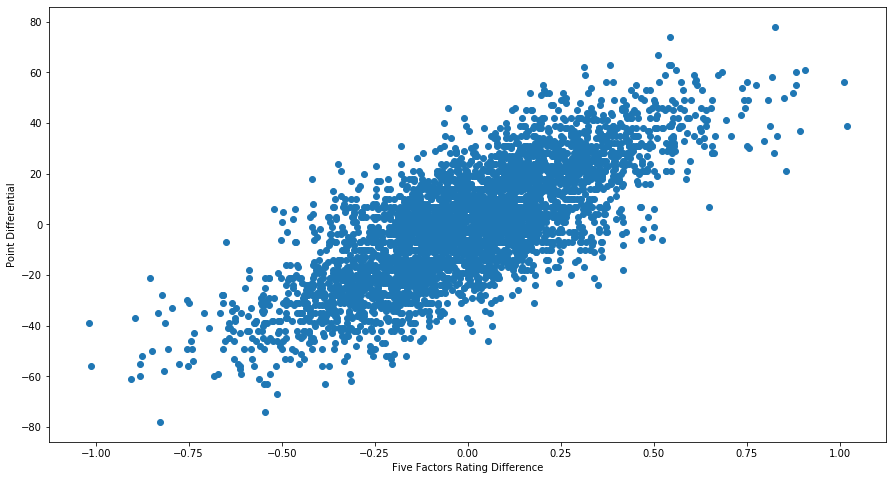

In [126]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
ax.scatter(stored_game_boxes['5FRDiff'], stored_game_boxes.PtsDiff);
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential");

In [127]:
# Eliminate outliers
# basis = stored_game_boxes[stored_game_boxes['5FRDiff'] != 0]
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes['PtsDiff']))
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3) & (stored_game_boxes['pts_z_score'] < 3)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [128]:
outliers

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Charlotte,14,-56,0.000059,0.250000,0.066667,3.616667,31.214286,1.000000,1.000000,0.071429,0.400000,0.98,-0.22,0.339421,-1.012484,3.921128,2.550601
1,Louisville,70,56,0.999941,0.681159,0.289855,9.275362,33.866667,4.666667,0.909091,0.733333,0.779661,1.20,0.22,1.351904,1.012484,3.921128,2.550601
0,Hawai'i,3,-60,0.000004,0.310345,0.103448,4.241379,27.000000,0.272727,0.250000,0.363636,0.486486,1.42,0.22,0.371772,-0.881703,3.414642,2.732787
1,Michigan,63,60,0.999996,0.694915,0.237288,8.694915,27.000000,7.000000,1.000000,0.777778,0.709091,1.20,-0.22,1.253475,0.881703,3.414642,2.732787
0,Bowling Green,10,-67,0.000005,0.319444,0.041667,3.388889,22.642857,0.714286,0.500000,0.285714,0.410256,0.66,0.44,0.340262,-0.512154,1.983460,3.051612
1,Ohio State,77,67,0.999995,0.641304,0.097826,8.282609,31.615385,5.923077,0.909091,0.846154,0.658824,0.22,-0.44,0.852416,0.512154,1.983460,3.051612
0,Bowling Green,3,-74,0.000002,0.297297,0.054054,3.878378,22.647059,0.176471,0.250000,0.235294,0.451613,1.32,0.88,0.356310,-0.544709,2.109537,3.370437
1,Memphis,77,74,0.999998,0.472973,0.202703,8.189189,33.588235,4.529412,1.000000,0.588235,0.625000,0.44,-0.88,0.901019,0.544709,2.109537,3.370437
0,Rutgers,0,-58,0.000006,0.240741,0.037037,2.222222,19.250000,0.000000,0.000000,0.000000,0.000000,0.49,-0.22,0.140585,-0.817478,3.165913,2.641694
1,Ohio State,58,58,0.999994,0.617978,0.146067,7.516854,35.181818,5.272727,0.900000,0.909091,0.621951,0.71,0.22,0.958063,0.817478,3.165913,2.641694


In [129]:
train_data.head()

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,31,-20,0.008141,0.500000,0.138889,6.652778,23.000000,2.583333,1.00,0.416667,0.604651,1.69,0.22,0.706398,-0.106235,0.411427,0.910929
0,Tulane,3,-4,0.649825,0.343284,0.089552,4.179104,25.800000,0.300000,0.25,0.400000,0.333333,0.44,0.22,0.357278,0.076127,0.294824,0.182186
0,Appalachian State,13,-7,0.834594,0.459016,0.049180,4.508197,26.500000,1.083333,0.40,0.416667,0.600000,1.91,-0.88,0.311751,-0.183410,0.710307,0.318825
1,Tennessee,20,7,0.165406,0.361111,0.027778,4.388889,32.818182,1.818182,0.80,0.454545,0.418605,2.79,0.88,0.495161,0.183410,0.710307,0.318825
1,Florida International,13,-21,0.005591,0.333333,0.101449,4.869565,30.142857,0.928571,0.60,0.357143,0.368421,1.15,0.66,0.491448,-0.058390,0.226131,0.956475


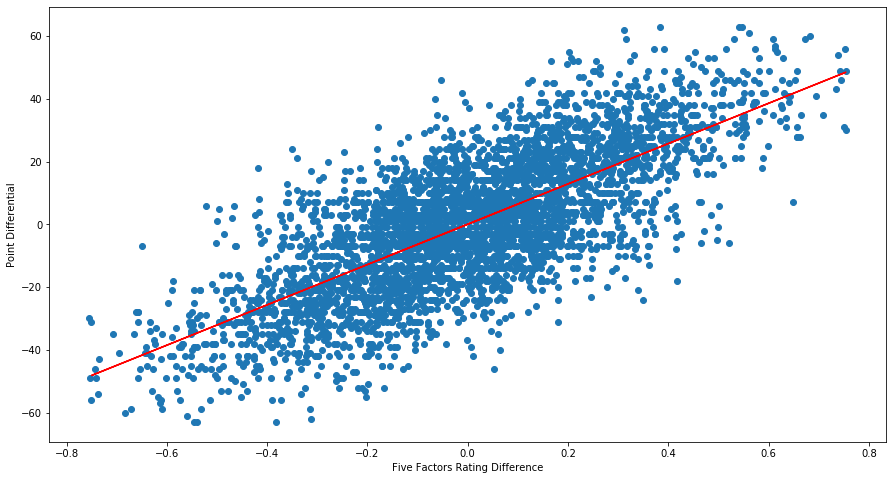

In [130]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

f, ax = plt.subplots(figsize=(15,8))
ax.scatter(basis['5FRDiff'], basis.PtsDiff)
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential")

xfit = test_data['5FRDiff']
yfit = model.predict(xfit[:, np.newaxis])
ax.plot(xfit, yfit, color='red', label='Linear Regression');

In [131]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

Linear Regression: y = 64.25887x + 0.03771


In [132]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = yfit.mean()
    std = yfit.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
    print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    print("")
    proj_point_diff = model.coef_[0] * stringify_entry(max_box_row['5FRDiff']) + model.intercept_
    print(f"Proj MOV by 5FRDiff: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")

In [133]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3
5FRDiff for Virginia Tech: 0.052567774458461725

Proj MOV by 5FRDiff: Virginia Tech by 3.0 (exact value: 3.4156579776040172)
Z score: 0.2213261061113076
Win Prob for Virginia Tech: 58.76%


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31,-3,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,1.15,-0.66,0.512424,-0.052568
1,Virginia Tech,34,3,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,1.81,0.66,0.564992,0.052568


In [134]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Could not find basic game data for game_id 401112488 locally, checking CFB Data API
Could not find drive data for game_id 401112488 locally, checking CFB Data API
Could not find play by play data for game_id 401112488 locally, checking CFB Data API
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7
5FRDiff for Georgia Tech: -0.15481740014756956

Proj MOV by 5FRDiff: Georgia Tech by -10.0 (exact value: -9.910678844747176)
Z score: -0.5983653069353325
Win Prob for Georgia Tech: 27.48%
Could not find basic game data for game_id 401112488 locally, checking CFB Data API
Could not find drive data for game_id 401112488 locally, checking CFB Data API
Could not find play by play data for game_id 401112488 locally, checking CFB Data API


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Georgia Tech,28,7,0.065752,0.376471,0.117647,5.000000,17.444444,3.111111,0.500000,0.444444,0.423077,0.93,-0.66,0.466866,-0.154817
1,Miami,21,-7,0.934248,0.390244,0.121951,5.841463,38.750000,1.750000,0.333333,0.750000,0.411765,1.59,0.66,0.621684,0.154817


In [135]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Could not find basic game data for game_id 401112513 locally, checking CFB Data API
Could not find drive data for game_id 401112513 locally, checking CFB Data API
Could not find play by play data for game_id 401112513 locally, checking CFB Data API
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2
5FRDiff for Georgia Tech: -0.130666867598198

Proj MOV by 5FRDiff: Georgia Tech by -8.0 (exact value: -8.358792930995262)
Z score: -0.5029101511421107
Win Prob for Georgia Tech: 30.75%
Could not find basic game data for game_id 401112513 locally, checking CFB Data API
Could not find drive data for game_id 401112513 locally, checking CFB Data API
Could not find play by play data for game_id 401112513 locally, checking CFB Data API


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,NC State,26,-2,0.156447,0.479167,0.177083,6.12500,23.700000,2.600000,0.833333,0.600000,0.561644,0.98,0.0,0.709716,0.130667
1,Georgia Tech,28,2,0.843553,0.379747,0.126582,5.64557,29.636364,2.545455,0.571429,0.636364,0.454545,0.98,0.0,0.579049,-0.130667


In [136]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Could not find basic game data for game_id 401110863 locally, checking CFB Data API
Could not find drive data for game_id 401110863 locally, checking CFB Data API
Could not find play by play data for game_id 401110863 locally, checking CFB Data API
Actual Winner: Mississippi State
MOV: Mississippi State by 1
5FRDiff for Mississippi State: 0.01594531126833254

Proj MOV by 5FRDiff: Mississippi State by 1.0 (exact value: 1.0623399033349508)
Z score: 0.07657555362561162
Win Prob for Mississippi State: 53.05%
Could not find basic game data for game_id 401110863 locally, checking CFB Data API
Could not find drive data for game_id 401110863 locally, checking CFB Data API
Could not find play by play data for game_id 401110863 locally, checking CFB Data API


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Ole Miss,20,-1,0.384124,0.400000,0.084211,4.800000,25.545455,1.818182,0.60,0.454545,0.470588,1.20,0.22,0.484127,-0.015945
1,Mississippi State,21,1,0.615876,0.369863,0.123288,4.821918,31.333333,1.750000,0.75,0.333333,0.500000,0.98,-0.22,0.500073,0.015945


In [137]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Actual Winner: Texas A&M
MOV: Texas A&M by 2
5FRDiff for Texas A&M: -0.035671978147348016

Proj MOV by 5FRDiff: Texas A&M by -2.0 (exact value: -2.2545287490018655)
Z score: -0.12744215872607007
Win Prob for Texas A&M: 44.93%


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,LSU,72,-2,0.321374,0.466667,0.088889,5.511111,46.176471,4.235294,0.916667,0.705882,0.520548,0.49,0.0,0.707957,0.035672
1,Texas A&M,74,2,0.678626,0.423077,0.105769,4.634615,45.157895,3.894737,0.923077,0.684211,0.505882,0.49,0.0,0.672285,-0.035672


,index,offense,defense,game_id,id,scoring,start_period,start_yardline,end_period,end_yardline,plays,yards,drive_result,year
52059,9184,LSU,Texas A&M,401012356,40101235623,True,5,25,5,32,4,-7,FG,2018
52060,9185,Texas A&M,LSU,401012356,40101235624,True,5,75,5,94,8,19,FG,2018
52061,9186,Texas A&M,LSU,401012356,40101235625,True,6,75,6,100,4,25,TD,2018
52062,9187,LSU,Texas A&M,401012356,40101235626,True,6,25,6,0,6,25,TD,2018
52063,9188,LSU,Texas A&M,401012356,40101235627,True,7,25,7,0,1,25,TD,2018
52064,9189,Texas A&M,LSU,401012356,40101235628,True,7,75,7,100,2,25,TD,2018
52065,9190,Texas A&M,LSU,401012356,40101235629,True,8,75,8,96,6,21,FG,2018
52066,9191,LSU,Texas A&M,401012356,40101235630,True,8,25,8,8,5,17,FG,2018
52067,9192,LSU,Texas A&M,401012356,40101235631,True,9,25,9,0,3,25,TD,2018
52068,9193,Texas A&M,LSU,401012356,40101235632,True,9,75,9,100,5,25,TD,2018
